# Predict rain based on other weather variables

This notebook will use time lags to train a machine learning model for predicting temprature. 

First, we select a random station. The data is kept at daily resolution. Then, we generate a lagged feature matrix.

In [1]:
import pandas as pd
import numpy as np
from numpy.random import randint
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import time
import glob
from mpl_toolkits.basemap import Basemap

In [2]:
data_dir = '/datasets/NOAA_SST/'
#load(data_dir + “noaa_gsod/…/file”
t0 = time.time()
data = pd.read_pickle(data_dir+'noaa_gsod/Combined_noaa_gsod') # load weather data
stations = pd.read_pickle(data_dir+'noaa_gsod.stations') # load station data

# # USE ONLY 2008-2018 # #
data = data.loc[data.index >= pd.Timestamp(2008, 1, 1)]
data = data.drop(columns=['yr','year','da','mo']) # don't need these anymore
print(time.time()-t0)

25.771286249160767


In [3]:
stations.head()

,usaf,wban,name,country,state,call,lat,lon,elev,begin,end
0,007018,99999,WXPOD 7018,None,None,None,0.00,0.000,+7018.0,20110309,20130730
1,007026,99999,WXPOD 7026,AF,None,None,0.00,0.000,+7026.0,20120713,20170822
2,007070,99999,WXPOD 7070,AF,None,None,0.00,0.000,+7070.0,20140923,20150926
3,008268,99999,WXPOD8278,AF,None,None,32.95,65.567,+1156.7,20100519,20120323
4,008307,99999,WXPOD 8318,AF,None,None,0.00,0.000,+8318.0,20100421,20100421


In [4]:
data.head()

,stn,temp,slp,wdsp,mxpsd,max,min,prcp
Datetime,,,,,,,,
2008-08-22,619970,41.7,1032.1,7.2,14.0,46.6,37.8,0.00
2008-09-28,714170,54.9,1023.8,9.1,15.0,70.3,51.4,0.06
2008-02-14,041560,35.6,1032.8,28.5,38.9,36.5,34.5,0.00
2008-02-25,041560,4.5,997.1,4.3,7.0,10.4,-1.1,0.00
2008-10-06,041650,43.3,998.8,24.3,30.9,44.6,40.3,0.00


In [5]:
# # SELECT RANDOM STATION # #
np.random.seed(3)
rs = np.unique(data['stn'].values) # find unique stations with data
rand_stat = rs[randint(len(rs))] # pick a random station

# # ideally we should check < len(np.unique(data.index)), but many are shorter
while (len(data.loc[data['stn'] == rand_stat]) < 3650): # If not enough data
    if len(stations.loc[stations['usaf'] == rand_stat]): # If station info available
        if (stations.loc[stations['usaf'] == rand_stat].iloc[0]['wban'] != '99999'): # If station number not unique
            rand_stat = rs[randint(len(rs))] # get a new station
    else:
        rand_stat = rs[randint(len(rs))] # get a new station

select_station = stations.loc[stations['usaf'] == rand_stat] # get location, etc, for random station

features = data.loc[data['stn'] == rand_stat] # pick weather at random station
features = features.drop(columns='stn')
features = features.drop(columns='max')
features = features.drop(columns='min')
features = features.sort_index()
select_station.head() # see where it is

,usaf,wban,name,country,state,call,lat,lon,elev,begin,end
5946,712220,99999,DEASE LAKE (AUT),CA,None,CWKX,58.433,-130.033,+0802.0,19930829,20190326


### Time-shift the data

In [6]:
columns = features.columns 
for co in columns:
    # one day lag
    features[co + '_lag1'] = features[co].shift(periods=1)
    
    # two days lag
    features[co + '_lag2'] = features[co].shift(periods=2)
    
    # three days lag
    features[co + '_lag3'] = features[co].shift(periods=3)
features = features.iloc[3:]
print(str(len(features)) + ' samples, ' + str(len(features.columns)) + ' features.')
features.head()

3926 samples, 20 features.


,temp,slp,wdsp,mxpsd,prcp,temp_lag1,temp_lag2,temp_lag3,slp_lag1,slp_lag2,slp_lag3,wdsp_lag1,wdsp_lag2,wdsp_lag3,mxpsd_lag1,mxpsd_lag2,mxpsd_lag3,prcp_lag1,prcp_lag2,prcp_lag3
Datetime,,,,,,,,,,,,,,,,,,,,
2008-01-04,9.5,982.6,2.4,5.8,0.08,5.5,0.0,-1.7,991.0,998.5,1024.8,4.6,2.5,1.7,7.0,7.0,4.9,0.00,0.00,0.00
2008-01-05,6.6,978.9,2.2,4.9,0.03,9.5,5.5,0.0,982.6,991.0,998.5,2.4,4.6,2.5,5.8,7.0,7.0,0.08,0.00,0.00
2008-01-06,11.4,987.0,2.8,5.8,0.12,6.6,9.5,5.5,978.9,982.6,991.0,2.2,2.4,4.6,4.9,5.8,7.0,0.03,0.08,0.00
2008-01-07,-7.3,1005.2,3.7,7.0,0.00,11.4,6.6,9.5,987.0,978.9,982.6,2.8,2.2,2.4,5.8,4.9,5.8,0.12,0.03,0.08
2008-01-08,-8.9,1005.8,5.3,9.9,0.00,-7.3,11.4,6.6,1005.2,987.0,978.9,3.7,2.8,2.2,7.0,5.8,4.9,0.00,0.12,0.03


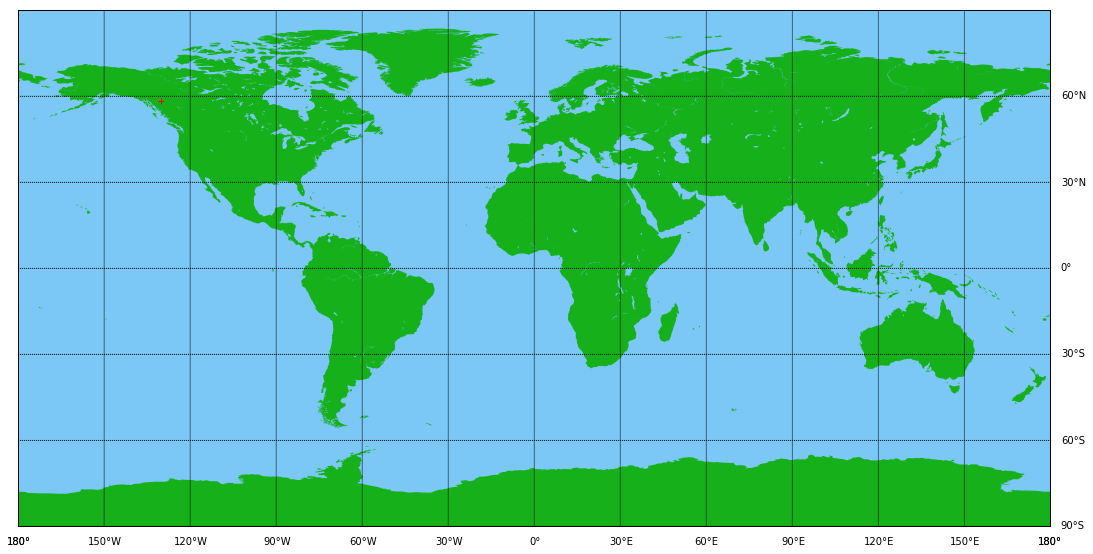

In [7]:
# Show the position of the station

fig = plt.figure(figsize=(18.5, 10.5))
m = Basemap(projection='cyl',llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=-180,urcrnrlon=180, resolution='l')
m.drawmapboundary(fill_color='xkcd:lightblue')
m.fillcontinents(color='xkcd:green',lake_color='xkcd:lightblue')
m.drawmeridians(np.arange(-180.,180.,30.),labels=[True,False,False,True])
m.drawparallels(np.arange(-90.,90,30.),labels=[False,True,True,False])
lon = select_station['lon'].tolist()
lat = select_station['lat'].tolist()
m.plot(lon, lat,'r+') 
plt.show()

### Create train/val/test

In [1]:
ylabel = features['temp'] # use today's temperature as the label
features = features.drop(columns='temp') # don't put it in training data!!

# Use 20% test split (80% training + validation)
ntrain = int(len(features)*0.8)
x_test = features.iloc[ntrain:,:]
y_test = ylabel[ntrain:]
indices = np.arange(ntrain)

# Split remaining 80% into training-validation sets (of original data)
x_train, x_val, y_train, y_val = train_test_split(features.iloc[0:ntrain,:], ylabel[0:ntrain], \
                                                    indices, test_size=0.2, random_state=1)

# Scale features. Fit scaler on training only.
scaler = MinMaxScaler() #scale features between 0 and 1
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

NameError: name 'features' is not defined

### Predict with Random Forest

In [9]:
# # Create, train, and predict random forest here # #

### Plot random forest

NameError: name 'y' is not defined

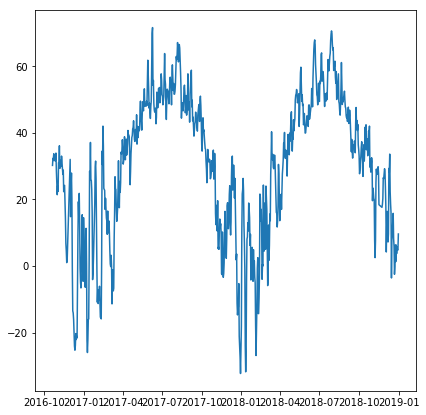

In [10]:
# plot predictions
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.plot(features.iloc[ntrain:].index,y_test) # plot actual temperature
plt.plot(features.iloc[ntrain:].index, y) # plot predicted temperature

# # PLOT TRAINING DATA HERE # #


# # INCREASE X TICK SPACING, UPDATE LEGEND # #
plt.xticks(features.index[::30], rotation = 45) # X-Ticks are spaced once every 30 days. 
myFmt = mdates.DateFormatter('%d-%b-%y') # This shows day-month-year. Switch to month-year or annually
plt.legend(('Wind speed','Random Forest Prediction'), fontsize=12, loc=1) # Add entries for training predictions and truth

plt.xticks(features.iloc[ntrain:].index[::30], rotation = 45) # set xticks to monthly
myFmt = mdates.DateFormatter('%b-%d-%y')
plt.gca().xaxis.set_major_formatter(myFmt)
plt.ylabel('Daily Temperature (degree Fahrenheit)', fontsize=12)
plt.legend(('Temperature','Random Forest Prediction'), fontsize=12, loc=1)
#plt.show()

# # Plot the feature importances # #
nfeatures = 10
fi = clf.feature_importances_ # get feature importances
fi_sort = np.argsort(fi)[::-1] # sort importances most to least
plt.subplot(1,2,2)
plt.bar(range(nfeatures), fi[fi_sort[0:nfeatures]], width=1, \
        tick_label=features.columns.values[[fi_sort[0:nfeatures]]]) # plot features importances
plt.ylabel('Feature Importance (avg across trees)', fontsize=12)
plt.xticks(rotation = 45)
plt.show()

### Feature importance is the weighted impurity of a branch adjusted by its children nodes and normalized by the impurities of all branches. The Random Forest feature importances are averaged over all regression trees.